# ch.9 GAN

## 9.1 GAN 기초

인공신경망인 생성자와 판별자로 구분  
번갈아 학습하며 경쟁적으로 학습을 진행하기에 적대적이라는 말이 붙음  
생성하는 모델


### 9.1.1 생성자와 판별자

Generator 생성자  
Discriminator 판별자

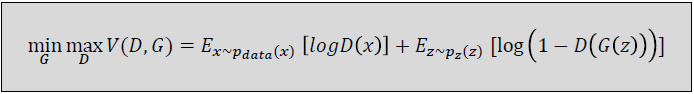

Generator

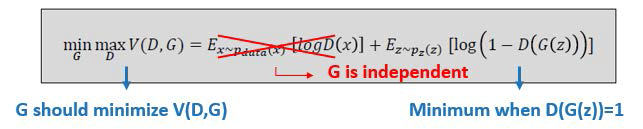

Discriminator

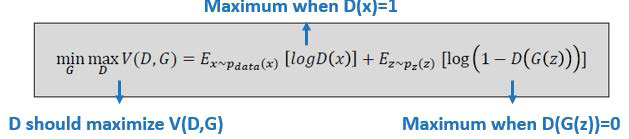

## 9.2 GAN 사용한 아이템 생성

### 9.2.1 학습 준비

In [16]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [17]:
# hyper-parameter 정의
EPOCH = 5
BATCH = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cpu')
print("장치 사용:", DEVICE)

장치 사용: cpu


In [18]:
# 사용 및 필요한 데이터셋 불러오기
trainset = datasets.FashionMNIST(
    './.data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]))

train_loader = torch.utils.data.DataLoader(
    dataset=trainset,
    batch_size=BATCH,
    shuffle=True
)

In [19]:
train_loader

In [20]:
trainset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./.data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

### 9.2.2 생성자 및 판별자 구현

#### Generator(생성자)

목표: 실제 데이터와 유사한 데이터를 만들어내는것이 목표  
정규분포로부터 뽑은 64차원의 무작위 텐서를 입력받아 행렬곱과 활성화 함수로 연산을 진행  
분포를 배워야하므로 무작위 텐서를 입력하여 단순한 분포로부터 실제 데이터의 복잡한 분포를 따라 하려함

In [21]:
G = nn.Sequential(nn.Linear(64,256),
                  nn.ReLU(),
                  nn.Linear(256,256),
                  nn.ReLU(),
                  nn.Linear(256,784),
                  nn.Tanh())

In [22]:
G

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

#### Discriminator(판별자)

목표: 생성자로부터 입력된 가짜 이미지를 판단하는 것이 목표  
앞서 받은 512차원의 데이터를 받아 행렬곱과 활성화 함수를 사용하여 받은 데이터가 생성자로부터 입력된 데이터인지 실제 이미지인지 판단함  
Sigmoid 함수를 사용하여 0~1사이의 값을 가지게 되며,  
0: 가짜/ 1: 진짜 이며 확률값이 계산된다.

In [23]:
D = nn.Sequential(
    nn.Linear(784, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid())

In [24]:
D

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

### 9.2.3 GAN 학습 구현

to() 함수를 사용하여 cpu or gpu로 학습에 쓰일 모델 보내기  
0 or 1 두개의 레이블만을 사용하기에 이진교차엔트로피(Binary Cross Entropy = BCE) 사용 + 최적화 'adam' 사용

출처: https://huggingface.co/transformers/main_classes/optimizer_schedules.html
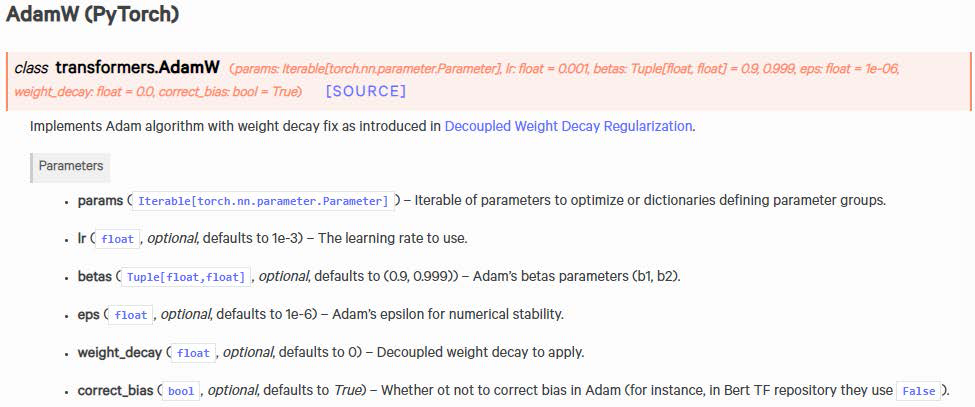

In [25]:
# 모델 보내기
D = D.to(DEVICE)
G = G.to(DEVICE)

# Ir = 학습rate
loss = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr = 0.0002)
g_optimizer = optim.Adam(G.parameters(), lr = 0.0002)

In [26]:
# GAN을 학습시키는 loop 생성

total_step = len(train_loader)

In [27]:
total_step

938

In [28]:
D

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [29]:
G

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [37]:
for epoch in range(EPOCH):
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(BATCH, -1).to(DEVICE)

        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH, 1).to(DEVICE)

        # 판별자가 진짜 이미지를 진짜로 인식하는 오차를 예산
        outputs = D(images)
        d_loss_real = loss(outputs, real_labels)
        real_score = outputs

        # 무작위 텐서로 가짜 이미지 생성
        z = torch.randn(BATCH, 64).to(DEVICE)
        fake_images = G(z)

        # 판별자가 가짜 이미지를 가짜로 인식하는 오차를 계산
        outputs = D(fake_images)
        d_loss_fake = loss(outputs, fake_labels)
        fake_score = outputs

        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss = d_loss_real + d_loss_fake

        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # 생성자가 판별자를 속였는지에 대한 오차를 계산
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = loss(outputs, real_labels)

        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    # 학습 진행 알아보기
    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
          .format(epoch, EPOCH, d_loss.item(), g_loss.item(),
                  real_score.mean().item(), fake_score.mean().item()))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x392 and 784x256)